# About

In [57]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text about organization of our code and this notebook

# Prerequisites 

(tbd) This notebook assumes that you:

- have internet access
- have a Google identity
- have configured a project under Google Cloud Platform (you can see how to complete this step in this tutorial)
- replace ##MY_PROJECT_ID## in the cell below with the ID of the GCP project you have confugured under your account

In [2]:
my_project_id = "idc-pathomics-000"

# Environment setup

In [5]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("Current directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

Current directory : /home/jupyter/idc-pathomics-use-case-1/src
Hostname          : idc-patho-vm
Username          : jupyter


In [6]:
!sudo apt-get update
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install -r ../requirements_cptac.txt # at the end, check whether all are required, maybe no requirement file needed, when only one/two things are installed
sys.path.append('/usr/local/lib/python3.7/dist-packages') # otherwise Openslide can not be loaded. Maybe find a better solution?!

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease                    
Hit:3 http://security.debian.org/debian-security buster/updates InRelease      
Hit:4 http://deb.debian.org/debian buster-backports InRelease                  
Hit:5 https://download.docker.com/linux/debian buster InRelease                
Hit:6 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease
Hit:7 https://nvidia.github.io/nvidia-container-runtime/stable/debian10/amd64  InRelease
Get:8 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease [6774 B]
Hit:9 https://nvidia.github.io/nvidia-docker/debian10/amd64  InRelease         
Hit:11 https://packages.cloud.google.com/apt google-fast-socket InRelease
Get:12 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease [5553 B]
Hit:10 https://packages.cloud.google.com/apt kubernetes-xenial InRelease
Hit:13 http://packages.cloud.google.com/a

In [67]:
# Import all required python libraries for this use case
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
# Create directories for input and output data 
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'
os.mkdir(input_dir)
os.mkdir(output_dir)

# Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they are available for the user on a [requester pays](https://cloud.google.com/storage/docs/requester-pays) basis. Currently, all pathology whole-slide images (WSI) are located in the `tbd` bucket.
**Metadata** for the DICOM files - including standard DICOM tags, but also non-DICOM metadata - are stored in BigQuery tables from which they can easily be accessed using standard SQL queries. This gives users the opportunity to explore available data by examining metadata without the need of downloading the DICOM data in the first place.

(How to find attributes we need?) 

(BigQuery magic, alternative: BigQuery client see https://cloud.google.com/bigquery/docs/visualize-jupyter?hl=de#pip) 

(Further information in IDC Documentation) 

(add project ID --> bigquery resultsa are stored in pandas dataframe) 

In [13]:
%%bigquery cohort_df --project=$my_project_id 

WITH dicom_all_extended AS (
    SELECT
        *,
        CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
             PixelMeasuresSequence[OFFSET(0)].
             PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    FROM idc-dev-etl.idc_v3.dicom_all
)
SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS cancer_subtype,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    pixel_spacing,
    gcs_url
FROM dicom_all_extended
WHERE
    NOT (ContainerIdentifier IS NULL)
    AND (ClinicalTrialProtocolID = "CPTAC-LUAD"
        OR ClinicalTrialProtocolID = "CPTAC-LSCC")
    -- pixel spacing between 0.00025 and 0.00051 mm corresponds to 20x magnification
    AND (pixel_spacing > 0.00025) AND (pixel_spacing < 0.00051)

Downloading: 100%|██████████| 2218/2218 [00:01<00:00, 1444.20rows/s]


Since up to now the information about the slide's tissue type (tumor tissue or normal tissue) is missing in the BQ table, we have to extract those from the attached TCIA metadata file and add them to our cohort's metadata. We remove slides that have no tissue type information available from our cohort. 

In [66]:
from data.utils import attach_tissue_type_information

tissue_type_data = pd.read_csv(os.path.join(input_dir, 'tissue_type_data_TCIA.csv'))
slides_metadata = attach_tissue_type_information(cohort_df, tissue_type_data)
slides_metadata_path = os.path.join(input_dir, 'slide_metadata.csv')
slides_metadata.to_csv(slides_metadata_path, index=False) # Save slides metadata as csv for later use

ValueError: cannot insert tissue_type, already exists

Using pandas and matplotlib functionality the user can have a look at the selected cohort's metadata and visualize some aspects of interest: 

In [134]:
print('Total number of slides in this cohort: ', len(slides_metadata))
nr_slides_from_luad_patients = slides_metadata.groupby('cancer_subtype').size()['luad'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'luad']) 
nr_slides_from_lscc_patients = slides_metadata.groupby('cancer_subtype').size()['lscc'] # or len(slides_metadata[slides_metadata['cancer_subtype'] == 'lscc'])
nr_luad_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['luad']
nr_lscc_patients = slides_metadata.drop_duplicates('patient_id').groupby('cancer_subtype').size()['lscc']
print('--> %d slides from %d LUAD patients' %(nr_slides_from_luad_patients, nr_luad_patients))
print('--> %d slides from %d LSCC patients' %(nr_slides_from_lscc_patients, nr_lscc_patients))

slides_metadata.head()

Total number of slides in this cohort:  2136
--> 1063 slides from 230 LUAD patients
--> 1073 slides from 211 LSCC patients


,slide_id,patient_id,cancer_subtype,tissue_type,width,height,pixel_spacing,gcs_url
0,C3L-00415-26,C3L-00415,lscc,normal,35855,25822,0.000494,gs://idc_v3_cptac_lscc/f087784e-9bae-407a-aa12...
1,C3L-00503-26,C3L-00503,lscc,normal,21911,28220,0.000494,gs://idc_v3_cptac_lscc/cf1a52ff-1a1b-41e3-9845...
2,C3L-00568-22,C3L-00568,lscc,tumor,17927,20798,0.000494,gs://idc_v3_cptac_lscc/16dc6535-ff33-4ddf-937d...
3,C3L-00604-22,C3L-00604,luad,tumor,19919,19378,0.000494,gs://idc_v3_cptac_luad/ea1c7876-c547-4abf-ab99...
4,C3L-00904-21,C3L-00904,lscc,tumor,37847,50544,0.000494,gs://idc_v3_cptac_lscc/770fd990-2125-4ec9-b518...


cancer_subtype  tissue_type
lscc            normal         384
                tumor          689
luad            normal         380
                tumor          683
dtype: int64


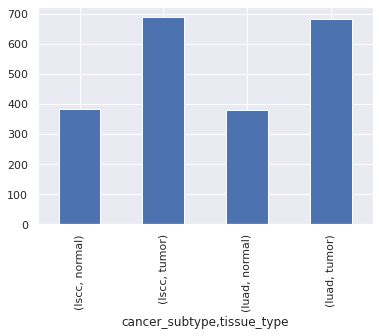

0
cancer_subtype tissue_type     
lscc           normal       384
               tumor        689
luad           normal       380
               tumor        683

In [150]:
# Displaying tissue type distribution
print(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size().plot(kind='bar', stacked=True)
plt.show()

pd.DataFrame(slides_metadata.groupby(['cancer_subtype', 'tissue_type']).size())
# how many slides per patient?

In [ ]:
# IDC viewer for some pathomics data? 
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/viewer/" + study_UID

# Pathomics use case

Text about experiments we are going to perfom 

## Preprocessing

In [15]:
from data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles_512')
os.makedir(slides_dir)
os.makedir(tiles_dir)

generate_tiles(slides_dir, os.path.join(input_dir, 'slides_metadata.csv'), tiles_dir, 'idc-pathomics-000')

os.remove(slides_dir) # delete because this directory is now empty and no longer required

Reading input data from /home/jupyter/idc_input/cptac_slides


Copying gs://idc_v3_cptac_lscc/79d63483-77aa-4b23-ab72-d7092dcf85fa.dcm...
/ [1 files][177.8 MiB/177.8 MiB]                                                
Operation completed over 1 objects/177.8 MiB.                                    


Processing: C3L-02629-26
15


Copying gs://idc_v3_cptac_lscc/77b8a091-3e05-4bde-aeaf-03d3b17fff7b.dcm...
| [1 files][436.4 MiB/436.4 MiB]                                                
Operation completed over 1 objects/436.4 MiB.                                    


Processing: C3L-02660-24
14


Copying gs://idc_v3_cptac_lscc/94b5b0bf-c514-4d74-9f84-d5ae6b328079.dcm...
/ [1 files][778.1 MiB/778.1 MiB]   55.6 MiB/s                                   
Operation completed over 1 objects/778.1 MiB.                                    


Processing: C3L-04749-26
15


KeyboardInterrupt: 

In [56]:
from data.tile_sorting_cptac import sort_tiles

#sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_cancer')
#sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'luad_lscc')
sort_tiles(tiles_dir, slides_metadata_path, input_dir, 'norm_luad_lscc')

## Training

In [ ]:
from data.data_set import Dataset
from model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc.csv'), num_classes=3)
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.01)
print(model)

model.train(dataset_train, batch_size=64, epochs=10, output_path=output_dir_experiment, validation_dataset=dataset_valid)
model.save(output_dir_experiment)
# how to select best model or simply take final model here? 

## Evaluation

In [ ]:
from evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'csv_test_mutations_split1_egfr.csv'), num_classes=2)
predictions = Predictions(model, test_dataset) 
predictions.save(os.path.join(output_dir, commit, 'predictions_testset_epoch28.json'))

In [ ]:
from evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions, experiment='binary_egfr')
roc_analysis.plot(os.path.join(output_dir, commit)) # make an inline plot
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir, commit, 'results_table_testset_epoch28.html'))

In [ ]:
from evaluation.heatmap import Heatmap 

colormaps=['coolwarm', 'coolwarm', 'coolwarm']
hm = Heatmap(predictions, 'TCGA-68-8250-01A-01-TS1.d6347fc6-c657-4d0f-bba9-09efde4991f3', colormaps)
hm.plot(os.path.join(output_dir, commit, 'heatmap.png'))

## Notes for improvement
- vielleicht ueberall funktionsparameter benennen zur besseren verstaendlichkeit**
- when displaying attributes of the dataset explain that from all patients we have healthy and tumor slide. 
- where to explain that we use gcl_url to download slides and tile them then? 